# Question 3: Decision Tree

Lee Chung Ho 3036030037

In [4]:
import random
from sklearn import tree
import pydot
from numpy.random import RandomState
from scipy import stats
import math
import graphviz
from six import StringIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

# Data Preparation

In [5]:
# path_class = r"/Users/dannylee/Desktop/HKU/22-23 SEM2/Data Mining/assignment/Assignment2/Exercise/skysurvey/training_class.csv"
path_class = r"C:\Users\user\Desktop\HKU\22-23 SEM2\Data Mining\assignment\Assignment2\DT\Exercise\skysurvey\training_class.csv"
# path_data = r"/Users/dannylee/Desktop/HKU/22-23 SEM2/Data Mining/assignment/Assignment2/Exercise/skysurvey/training_data.csv"
path_data = r"C:\Users\user\Desktop\HKU\22-23 SEM2\Data Mining\assignment\Assignment2\DT\Exercise\skysurvey\training_data.csv"

In [6]:
feature = ['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'rerun', 'camcol', 'field', 'specobjid', 'redshift', 'plate', 'mjd', 'fiberid']
target = ['star','galaxy','quasar']
label = np.asarray(pd.read_csv(path_class, header = None)[0])
data = np.asarray(pd.read_csv(path_data, header = None))

# Modeling

Decision tree classifier is a strong but simple machine learning method that is based on splitting the attributes according to certain criterions on given class, such as minimizing gini impurity or maximizing information gain in each split, to obtain useful information from the dataset.  
We are building a Decision tree classifier on the Sloan Digital Sky Survey (SDSS) dataset.  
  
**Question 3-1**  
We set random state 2018, min leaf 0.01 (training data per leaf is 1% for significant result), and all other parameters set as default (default split criterion is gini).

In [7]:
def plot_tree(model):
    dot_data = tree.export_graphviz(model, out_file=None, 
                         feature_names=feature,  
                         class_names=target,  
                         filled=True, rounded=True,  
                         special_characters=True)  
    graphv = graphviz.Source(dot_data)
    return graphv

def save_tree(model,path):
    dot_data = StringIO()
    tree.export_graphviz(model, out_file=dot_data, feature_names=feature,  
                         class_names=target,  
                         filled=True, rounded=True,  
                         special_characters=True)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())
    return graph[0].write_pdf(path)

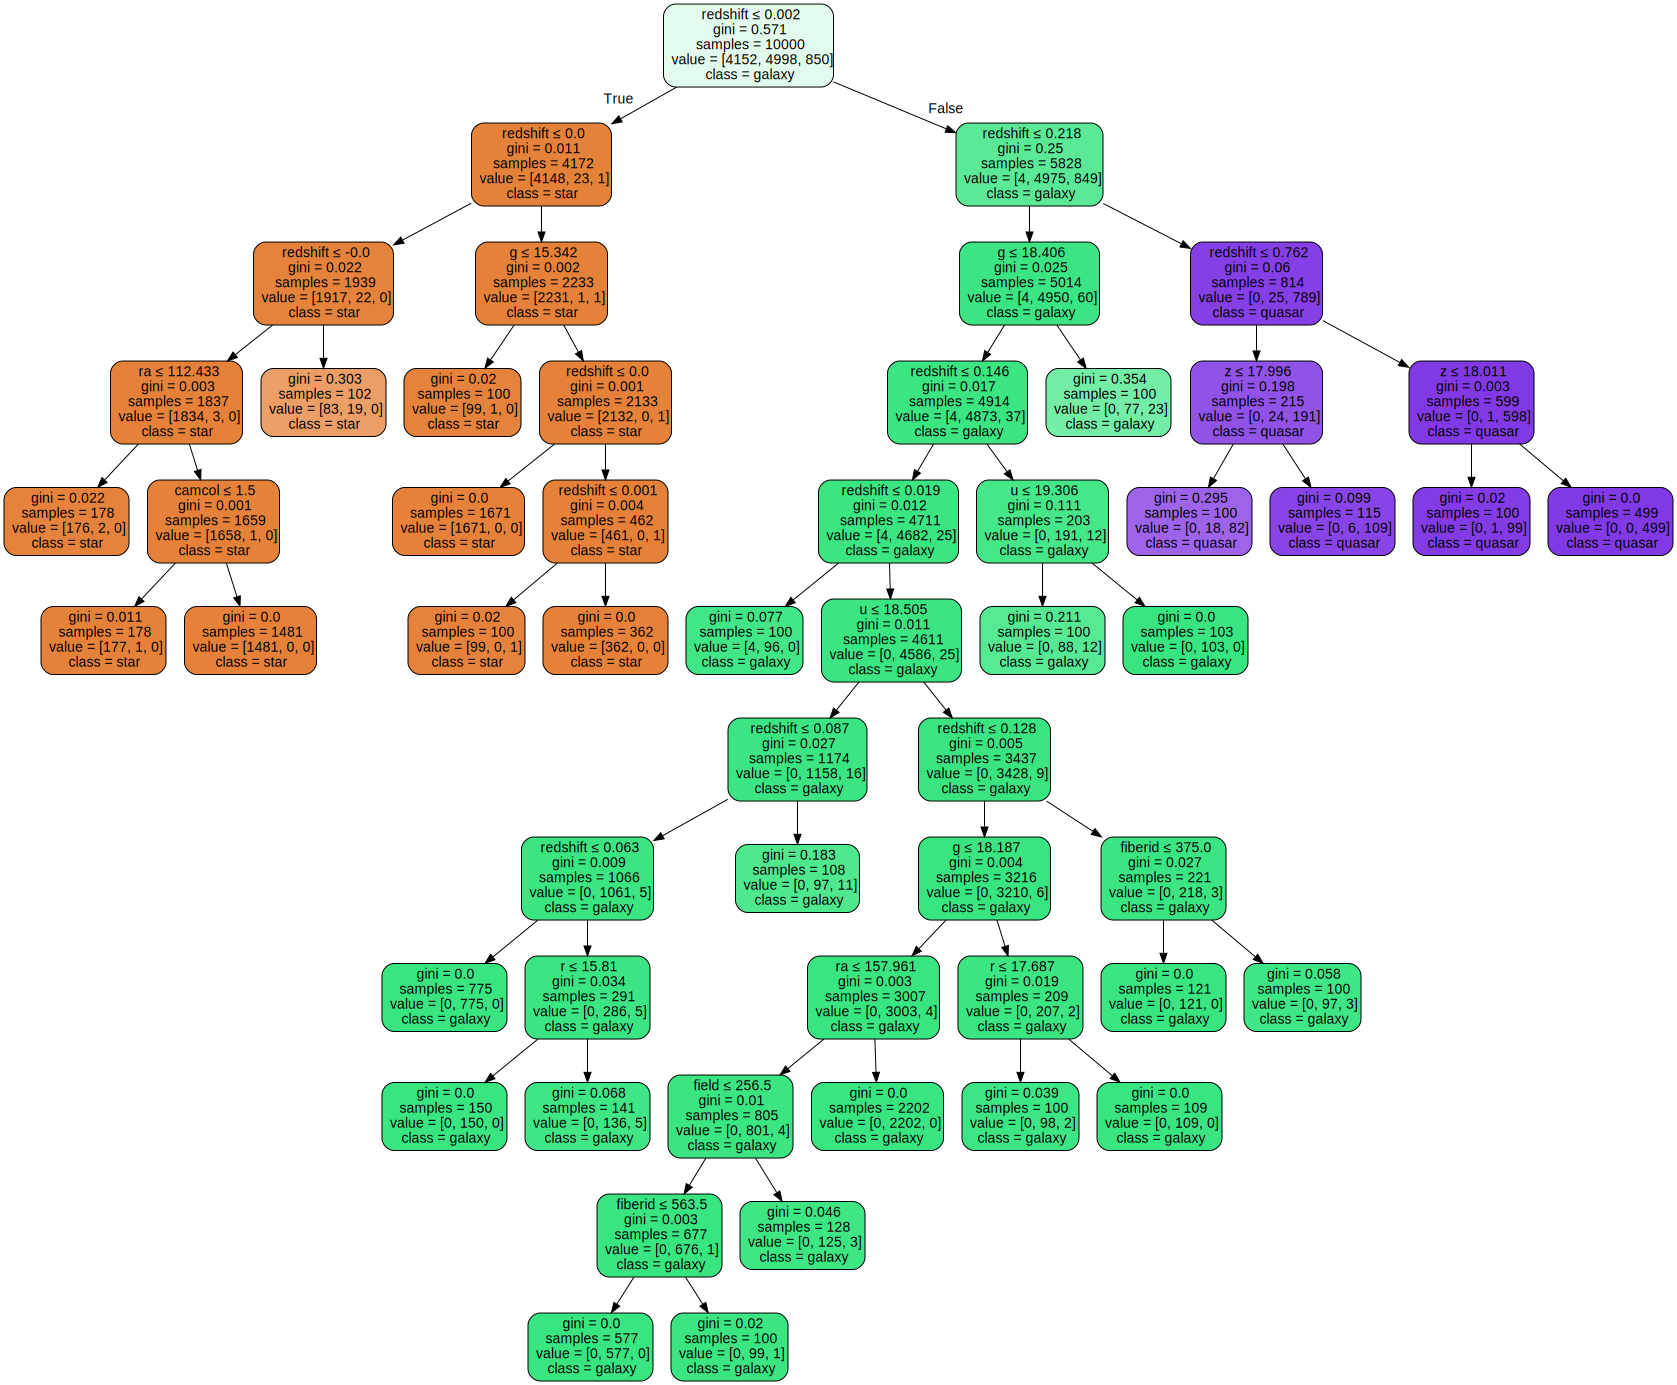

In [8]:
clf = tree.DecisionTreeClassifier(min_samples_leaf=0.01, random_state=RandomState(2018))
clf = clf.fit(data, label)

plot_tree(clf)

In [6]:
# save to PDF
path = r"/Users/dannylee/Desktop/HKU/22-23 SEM2/Data Mining/assignment/Assignment2/Exercise/skysurvey/Question3-1.pdf"
save_tree(clf,path)

In [16]:
print ("Training accuracy of the decision tree classifier is "+str((clf.score(data,label))))
print ("No. of mis-classified records (training error) in total 10000 records is "+str(round((1 - clf.score(data,label)) * len(data))))

Training accuracy of the decision tree classifier is 0.9887
No. of mis-classified records (training error) in total 10000 records is 113


# Generalization error

Generalization error a measure to pose penalty on the complexity of the tree.  
It is given by:  
Gener. error (model) = training error (model, training data) + alpha * complexity (model)  
Where complexity (model) = no. of leaves, Alpha = coefficient for penalty on complexity  

In [10]:
def leaves(model):
    count = [x for x in model.tree_.children_left if x == -1]
    return len(count)

In [11]:
def gener_error(model, data, label, alpha):
    training_error = round((1 - clf.score(data,label)) * len(data))
    gen_error = training_error + alpha*leaves(model)
    return gen_error

In [17]:
print ("No. of mis-classified records (training error) in total 10000 records is "+str(round((1 - clf.score(data,label)) * len(data))))
print(f'The complexity of the current tree is {leaves(clf)}')

No. of mis-classified records (training error) in total 10000 records is 113
The complexity of the current tree is 28


**Question 3-2**  
Generally, we take alpha as 0.5:

In [13]:
print(f"If Alpha = 0.5, the generalization error of the current tree is {gener_error(clf, data, label, 0.5)}")

If Alpha = 0.5, the generalization error of the current tree is 127.0


We can also visualize the effect of alpha on the generalization error of our model:

In [11]:
error = []
for i in np.arange(0,1.1,0.1):
    error.append(gener_error(clf, data, label, i))

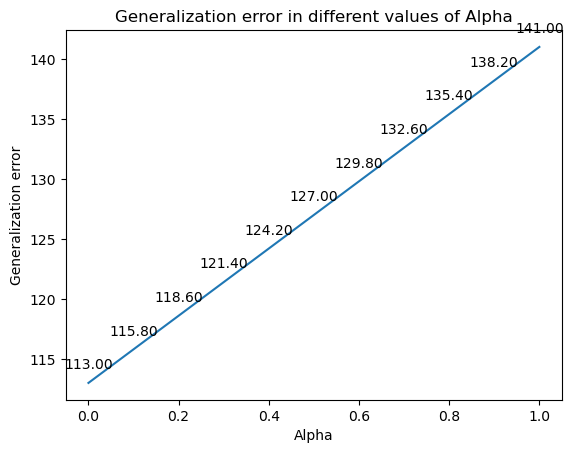

In [12]:
plt.plot(np.arange(0,1.1,0.1),error)
plt.xlabel("Alpha")
plt.ylabel("Generalization error")
plt.title("Generalization error in different values of Alpha")
for x,y in zip(np.arange(0,1.1,0.1),error):
    text = "{:.2f}".format(y)
    plt.annotate(text,
                 (x,y),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center')
plt.show()

# Tree depth parametric tuning

We can control the max depth of the tree, which means the tree will stop growing (splitting) once the max depth is reached.  
we compare the generalization error of trees in different depth.

In [18]:
print(f'The depth of the current tree is {clf.tree_.max_depth}')
print(f'The complexity of the current tree is {leaves(clf)}')

The depth of the current tree is 11
The complexity of the current tree is 28


**Question 3-3**  
Let's do a search from 1 to 11,  
Rationale: 1 is the minimum number of depth parameter, while 11 is the current depth with no max limit (fully grown), so it is trivial to set a max depth larger than 11.  
We use 0.5 as alpha to punish complexity.

In [19]:
gen = []
for i in range(1, 12):
    clf = tree.DecisionTreeClassifier(max_depth=i, min_samples_leaf=0.01, random_state=RandomState(2018))
    clf = clf.fit(data, label)
    gen.append(gener_error(clf, data, label, 0.5))

In [20]:
print(f'With max tree depth = {[gen.index(x) for x in gen if x == min(gen)][0]+1}, the lowest generalization error is {min(gen)}')

With max tree depth = 2, the lowest generalization error is 115.0


In [21]:
clf = tree.DecisionTreeClassifier(max_depth=2, min_samples_leaf=0.01, random_state=RandomState(2018))
clf = clf.fit(data, label)
print(f"In such case, the training error after reducing the max tree depth is still {round((1 - clf.score(data,label)) * len(data))}")
print(f"While maintaining the same training error, the number of leaves(complexity) is greatly reduced from 28 to {leaves(clf)}")

In such case, the training error after reducing the max tree depth is still 113
While maintaining the same training error, the number of leaves(complexity) is greatly reduced from 28 to 4


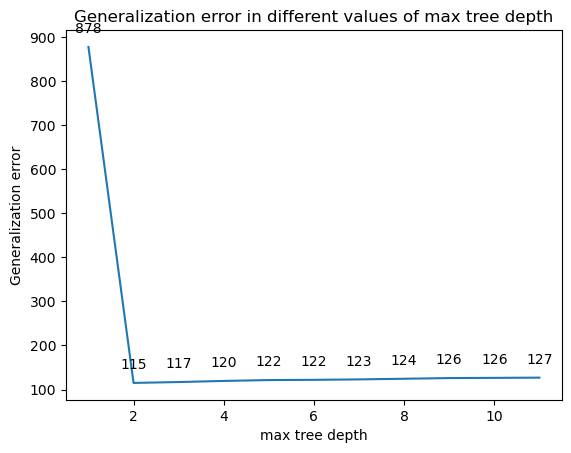

In [22]:
plt.plot(range(1, 12),gen)
plt.xlabel("max tree depth")
plt.ylabel("Generalization error")
plt.title("Generalization error in different values of max tree depth")
for x,y in zip(range(1, 12),gen):
    text = "{:.0f}".format(y)
    plt.annotate(text,
                 (x,y),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center')
plt.show()

Given that  
Gener. error (model) = training error (model, training data) + alpha * complexity (model)  
The **decrease of max tree depth** can reduce the generalization error, beacuse it can prevent the tree from over-growing, therefore fewer leaves will be grown and reduce complexity of the model.  
However, if max tree depth is too low, the training error may be large, increasing the generalization error.  
Note that in some cases, if we choose a **different alpha**, the optimal max tree depth may change and may not be 2.  

**Question 3-4**  
The decision tree with optimal max depth=2 is Illustrated below.  
Comparing to the tree in 3-1 above, this tree is much simpler.  
1. Anyone who look at the tree can easily understand which attributes are affecting the class the most.
2. Classification task can be done more efficiently because the time for a new sample classification increases with the depth of the tree, as the task has be done searching from the root to the bottom of the tree. This benefit is significant when we need to classify a large amount of data.   

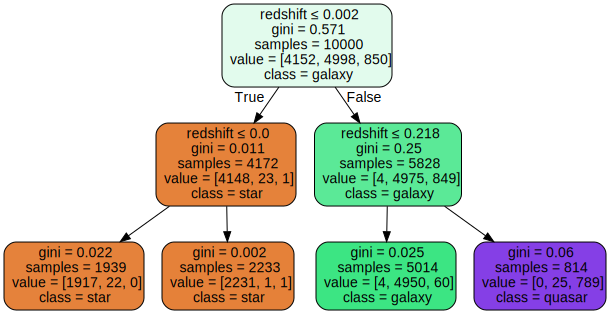

In [23]:
clf = tree.DecisionTreeClassifier(max_depth=2, min_samples_leaf=0.01, random_state=RandomState(2018))
clf = clf.fit(data, label)
plot_tree(clf)

In [19]:
# save to PDF
path = r"/Users/dannylee/Desktop/HKU/22-23 SEM2/Data Mining/assignment/Assignment2/Exercise/skysurvey/Question3-3.pdf"
save_tree(clf,path)

**Question 3-5**  
Let's pick 1 sample from the data set. The table below shows the details of the 1001st sample in the dataset.  

In [24]:
df = pd.DataFrame(columns=feature)
df.loc[len(df)] = data[1000]
df

,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,redshift,plate,mjd,fiberid
0,148.975411,0.332933,18.22104,17.05559,16.58764,16.29906,16.09243,756.0,301.0,4.0,221.0,3.007866e+17,0.047478,267.0,51608.0,623.0


Looking at the tree above, we first see whether redshift ≤ 0.002. The sample has a redshift=0.047478, which is >0.002. So, it goes to the right child of the root node.  
Then we check whether redshift ≤ 0.218. The sample has a redshift > 0.218. It goes to the right child node.  
The class of the node is quasar. This sample should be classified as quasar.  
Both 2 splits are based on the attribute "redshift". redshift should be most relevant.

In fact, it is obvious to see that redshift is most relevant. Looking at **every non-leave node**, all the splits are based on redshift.  
Below is the plot of feaure importance showing that redshift determines the classification results:

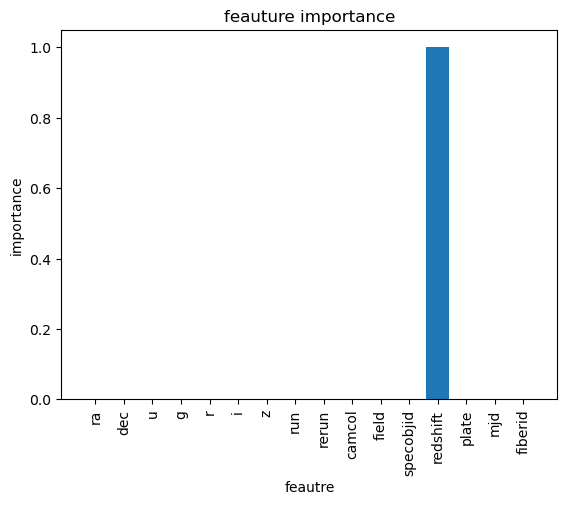

In [25]:
plt.bar(feature, clf.feature_importances_)
plt.xlabel("feautre")
plt.ylabel("importance")
plt.title("feauture importance")
plt.xticks(rotation=90)
plt.show()

**Question 3-6**  
Yes, the decision tree can still be pruned. Referring to the tree illustrated in 3-4, the left child of the root node is in class "star".  
The two children of this node is also in the same class "star".  
That means, after the first split, all the data are already classified as class "star", no matter which child node it goes in the second split.  
So this split can be pruned to further reduce the complexity of the tree thus the generalization error.   

# Post pruning

**Question 3-7**

Let's prune the children of the left child of the root node as mentioned in 3-6:

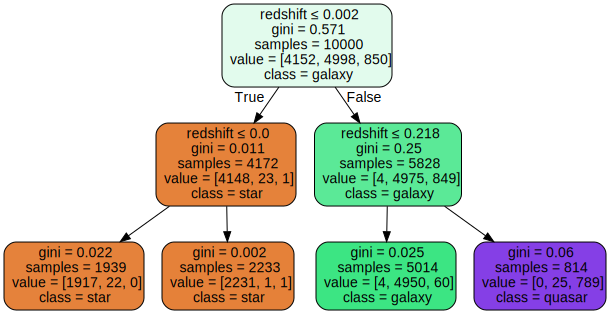

In [26]:
plot_tree(clf)

In [27]:
pruned_tree = copy.deepcopy(clf)
pruned_tree.tree_.children_left[1] = -1
pruned_tree.tree_.children_right[1] = -1

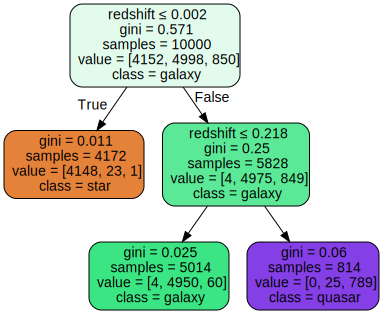

In [28]:
plot_tree(pruned_tree)

Now the tree has only 3 leaves. The complexity is reduced from 4 leaves to 3 leaves. Then, we write a simple for loop to compute the training error of the pruned tree (we access the splitting condition on redshift of the nodes by clf.tree_.threshold):  

In [24]:
prediction = []
for x in data:
    if x[12]  > clf.tree_.threshold[0]:
        if x[12] >clf.tree_.threshold[4]:
            prediction.append(int(2))
        else:
            prediction.append(int(1))
    else:
        prediction.append(int(0))
print(f"The training error of the pruned tree is {(label != prediction).sum()}")

The training error of the pruned tree is 113


In [25]:
print(f'By Gener. error (model) = training error (model, training data) + alpha * complexity (model),\nthe pruned tree has a generalization error of {113+0.5*3}, which is lower than that of the original tree ({gener_error(clf, data, label, 0.5)})')

By Gener. error (model) = training error (model, training data) + alpha * complexity (model),
the pruned tree has a generalization error of 114.5, which is lower than that of the original tree (115.0)


**With the same logic, let's look at the other splits**  
We first see how the generalization error goes if we **continue to prune** the children of the right child of the root node.

In [31]:
prediction = []
for x in data:
    if x[12]  > clf.tree_.threshold[0]:
            prediction.append(int(1))
    else:
        prediction.append(int(0))
print(f"If we prune the the children of the right child of the root node, The training error of the pruned tree is {(label != prediction).sum()}")
print("And the number of leaves will futther be reduced to 2.")
print(f'With Alpha=0.5, the pruned tree has a generalization error of {(label != prediction).sum()+0.5*2}, which is higher than that of the original tree ({gener_error(clf, data, label, 0.5)}).')
print("So this split should not be pruned.")

If we prune the the children of the right child of the root node, The training error of the pruned tree is 877
And the number of leaves will futther be reduced to 2.
With Alpha=0.5, the pruned tree has a generalization error of 878.0, which is higher than that of the original tree (115.0).
So this split should not be pruned.


Then, what if we prune the children of the root node? (the class of the root node is galaxy, so all the samples are classified as galaxy, and there is only 1 leaf: the root node itself)

In [32]:
prediction = []
for x in data:
    prediction.append(int(1))
print(f"If we prune the the children of the right child of the root node, The training error of the pruned tree is {(label != prediction).sum()}")
print("And the number of leaves will futther be reduced to 2.")
print(f'With Alpha=0.5, the pruned tree has a generalization error of {(label != prediction).sum()+0.5*1}, which is higher than that of the original tree ({gener_error(clf, data, label, 0.5)}).')
print("So this split should not be pruned.")

If we prune the the children of the right child of the root node, The training error of the pruned tree is 5002
And the number of leaves will futther be reduced to 2.
With Alpha=0.5, the pruned tree has a generalization error of 5002.5, which is higher than that of the original tree (115.0).
So this split should not be pruned.


In conclusion, we should only prune **1** split out of the **3** splits in the tree, which is the one we mentioned in Question 3-6.  
After pruning the tree, the same training accuracy is achieved with a reduced tree complexity, so the geneeralization error is improved after pruning, with generalization error being reduced from 115 to 114.5  
The final pruned tree is illustrated below:

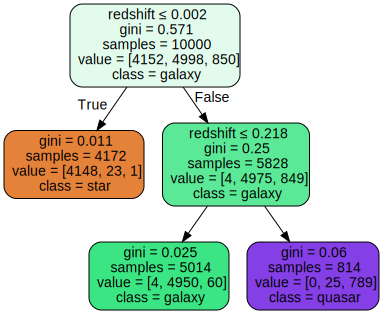

In [33]:
plot_tree(pruned_tree)

In [26]:
# save to PDF
path = r"/Users/dannylee/Desktop/HKU/22-23 SEM2/Data Mining/assignment/Assignment2/Exercise/skysurvey/Question3-7.pdf"
save_tree(pruned_tree,path)